*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.


In [3]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# helps in text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping




print(tf.__version__)

     |████████████████████████████████| 453.4MB 37kB/s 
     |████████████████████████████████| 4.0MB 54.0MB/s 
     |████████████████████████████████| 4.0MB 51.2MB/s 
     |████████████████████████████████| 6.0MB 37.4MB/s 
     |████████████████████████████████| 471kB 43.3MB/s 
     |████████████████████████████████| 3.9MB 48.9MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10

In [4]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2021-03-23 15:15:54--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/tab-separated-values]
Saving to: ‘train-data.tsv.1’

train-data.tsv.1        [  <=>               ] 349.84K   937KB/s    in 0.4s    

2021-03-23 15:15:54 (937 KB/s) - ‘train-data.tsv.1’ saved [358233]

--2021-03-23 15:15:55--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/tab-separated-values]
Saving to: ‘valid-data.tsv.1’

valid-data.tsv.1        [ <=>            

Preparando dataset e separando Labels

In [5]:
train_file = pd.read_table(train_file_path, header=None)
test_file = pd.read_table(test_file_path, header=None)

In [6]:
#separando X/Y train_file
X_train = train_file[1]
Y_train = np.array(train_file[0].to_list())

In [7]:
#separando test_file
X_test = test_file[1]
Y_test = np.array(test_file[0].to_list())

In [8]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

**Pré-processando os dados** </br>
Usando o Tokenizer do tensorflow não existe a necessidade de retirar nenhum caracteres especiais já que a propria função reconhece e não adiciona mais uma palavra, apenas entende que é a mesma.

In [25]:
t = Tokenizer(vocab_size,oov_token=oov_tok)
t.fit_on_texts(X_train)

word_index = t.word_index

X_train_t = t.texts_to_sequences(X_train)
training_padded = pad_sequences(X_train_t, maxlen=max_length, padding=padding_type, truncating=trunc_type)


X_test_t = t.texts_to_sequences(X_test)
testing_padded = pad_sequences(X_test_t, maxlen=max_length, padding=padding_type, truncating=trunc_type)

Usei a biblioteca preprocessing do sklearn cara fazer o encode das labels, não havia necessidade pois eram apenas 2 valores únicos, mas é uma boa forma de treinar para quando houver mais de um.

In [26]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(Y_train)
test_y = le.transform(Y_test)

Segundo o próprio projeto de Natural Language Process que o TensorFlow disponibiliza, esse passo abaixo é necessário para funcionar com TensorFlow 2.x </br>
https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%202%20-%20Lesson%202.ipynb

In [27]:
training_padded = np.array(training_padded)
train_label = np.array(train_y)
testing_padded = np.array(testing_padded)
test_label = np.array(test_y)

Existe outros 2 modelos onde em vez de GlobalAvaregePooling1D, nós usamos LTSM e Bidirecional LTSM, sendo que esses dois tem mais acurácia

In [28]:
model = keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [33]:
num_epochs = 30
history = model.fit(training_padded, train_label, epochs=num_epochs, validation_data=(testing_padded, test_label), verbose=2)

Epoch 1/30
131/131 - 1s - loss: 0.5218 - accuracy: 0.8631 - val_loss: 0.3673 - val_accuracy: 0.8657
Epoch 2/30
131/131 - 0s - loss: 0.3506 - accuracy: 0.8660 - val_loss: 0.3395 - val_accuracy: 0.8657
Epoch 3/30
131/131 - 0s - loss: 0.3218 - accuracy: 0.8660 - val_loss: 0.3073 - val_accuracy: 0.8657
Epoch 4/30
131/131 - 0s - loss: 0.2737 - accuracy: 0.8667 - val_loss: 0.2393 - val_accuracy: 0.8678
Epoch 5/30
131/131 - 0s - loss: 0.1810 - accuracy: 0.9222 - val_loss: 0.1419 - val_accuracy: 0.9497
Epoch 6/30
131/131 - 0s - loss: 0.0961 - accuracy: 0.9734 - val_loss: 0.0873 - val_accuracy: 0.9777
Epoch 7/30
131/131 - 0s - loss: 0.0580 - accuracy: 0.9854 - val_loss: 0.0674 - val_accuracy: 0.9784
Epoch 8/30
131/131 - 0s - loss: 0.0425 - accuracy: 0.9892 - val_loss: 0.0588 - val_accuracy: 0.9799
Epoch 9/30
131/131 - 0s - loss: 0.0337 - accuracy: 0.9904 - val_loss: 0.0533 - val_accuracy: 0.9813
Epoch 10/30
131/131 - 0s - loss: 0.0277 - accuracy: 0.9926 - val_loss: 0.0503 - val_accuracy: 0.9835

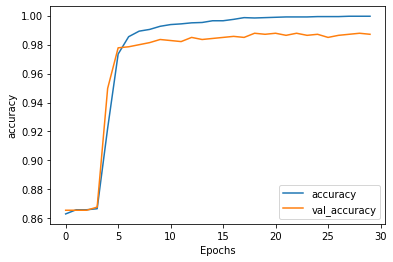

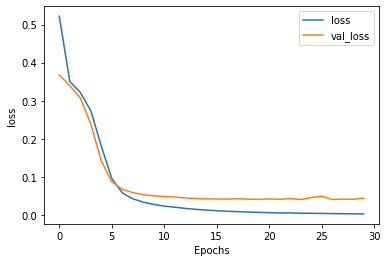

In [35]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [76]:
sentence = ["sale today! to stop texts call 98912460324"]

In [77]:
def previsao(sentence):
  sequences = t.texts_to_sequences(sentence)
  padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
  print(model.predict(padded))

previsao(sentence)

[[0.5528873]]


In [89]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])

def predict_message(sentence):
  sequences = t.texts_to_sequences([sentence])
  padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
  return (float(model.predict(padded)), 'ham' if model.predict(padded) < 0.5 else 'spam' )

In [91]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):   
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


You passed the challenge. Great job!
